In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.model_selection import train_test_split as tts
from collections import defaultdict

In [2]:
df=pd.read_csv("ratings_Electronics.csv",names=["userId", "productId", "ratings", "timestamp"])

In [3]:
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
df.shape

(7824482, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [7]:
df.isna().any()

userId       False
productId    False
ratings      False
timestamp    False
dtype: bool

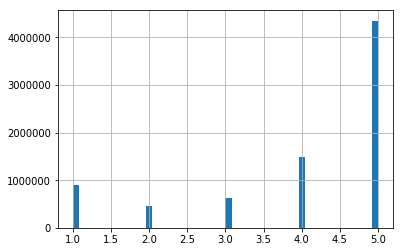

In [8]:
df['ratings'].hist(bins=50)

In [9]:
user_countings=df.groupby("userId")["ratings"].count()

In [10]:
user_countings

userId
A00000262KYZUE4J55XGL     1
A000063614T1OE0BUSKUT     2
A00009182QVLSWIGHLS1B     1
A00009661LC9LQPGKJ24G     1
A00010809P09NUU6ZP6H      1
A00014061C2IZNE0YEILY     1
A000145014WOTZJ5NSKOR     1
A00015222LZ55IJSVL5IX     1
A00015228CUPGPF957DS      1
A0001528BGUBOEVR6T5U      4
A00018041RRVMCICCAP79     2
A000186437REL8X2RW8UW     1
A000187635I595IAVSQLH     2
A00019466UY2KR1IPXQN      1
A0002012T7HVDB2EF4RH      1
A0002032ZFQKDVHYKGWR      1
A0002550196XWX0PEOZND     1
A00027081JC8NE8X6TD5      1
A00027561NC7JTXEP3EOD     1
A00028781NF0U7YEN9U19     1
A00029263J863WSR0TDRS     1
A000294826HEMAY5L3K1H     1
A00029825UMZ6N0ETLHY      1
A00033481VZEEGYXEN32T     3
A00037441I8XOQJSUWCAG     3
A00038802J7X43YTW44TD     2
A000428226SAAAIBK8I36     1
A0004478EF5NFPHLGCWG      1
A00045341JXVKNK93M6JE     1
A00059641RDIAMDC7IJRZ     1
                         ..
AZZYJH0XNZ896             1
AZZYK2BT6EU8V             2
AZZYKX2KZ0Q82             1
AZZYMQZHES0KT             1
AZZYO4XQYE89O

In [11]:
merged_df=pd.merge(df,user_countings,on="userId")

In [12]:
merged_df.columns=["userId","productId","ratings","timestamp","no_of_users_rated_this_product"]

In [13]:
merged_df.head()

,userId,productId,ratings,timestamp,no_of_users_rated_this_product
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,2
1,AKM1MP6P0OYPR,B005UEB5TQ,5.0,1366243200,2
2,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,4
3,A2CX7LUOHB2NDG,B000W3LJ6Y,5.0,1344988800,4
4,A2CX7LUOHB2NDG,B001EYU79A,5.0,1349222400,4


In [14]:
merged_df=merged_df[merged_df["no_of_users_rated_this_product"]>50]

In [15]:
merged_df.drop(["no_of_users_rated_this_product"],axis=1,inplace=True)

In [16]:
merged_df.columns

Index(['userId', 'productId', 'ratings', 'timestamp'], dtype='object')

In [17]:
merged_df.head()

,userId,productId,ratings,timestamp
444,AT09WGFUM934H,0594481813,3.0,1377907200
445,AT09WGFUM934H,B00005105L,5.0,1377475200
446,AT09WGFUM934H,B000068O1M,5.0,1384905600
447,AT09WGFUM934H,B000068O34,5.0,1384732800
448,AT09WGFUM934H,B000068O4J,5.0,1387238400


In [18]:
len(merged_df)

122171

In [19]:
merged_df=merged_df.sample(n=12000)

In [20]:
label_encoder = preprocessing.LabelEncoder()

In [21]:
merged_df['userId_encoded']= label_encoder.fit_transform(merged_df['userId']) 

In [22]:
merged_df["productId_encoded"]=label_encoder.fit_transform(merged_df["productId"])

In [23]:
merged_df.head()

,userId,productId,ratings,timestamp,userId_encoded,productId_encoded
559726,A11EYMH9UV9XG7,B009APC0R2,5.0,1382918400,20,7432
737340,AMWL7XIWIPXEZ,B00CO8TBQ0,4.0,1382745600,1317,8114
622500,A8CKH8XB33XGN,B008D4X4GW,4.0,1372982400,1167,7089
232366,A1GBU479WXR7UG,B005PYD2RE,5.0,1351987200,180,6208
522453,A3DL29NLZ7SXXG,B00275G10O,5.0,1367193600,913,3409


In [24]:
train_data,test_data=tts(merged_df,test_size=0.20)

# Building Popularity Based Recommendation System

In [25]:
def popularity_based_rs(train_data):
    popularity_df=pd.DataFrame(train_data.groupby("productId")["ratings"].mean())
    popularity_df=popularity_df.reset_index()
    popularity_df.columns=["productId","AvgRatings"]
    popularity_df.sort_values(by=['AvgRatings'],ascending=False,inplace=True)    
    products_referred=popularity_df.head()["productId"].values
    print("Top Products and Ratings:\n\n",popularity_df.head())
    print("\nSo Products Referred to the user will be:\n\n",products_referred)

In [26]:
recommend_to_user_A74UT8IQCM0I2=popularity_based_rs(train_data)

Top Products and Ratings:

        productId  AvgRatings
7465  B00L43HAY6         5.0
5947  B008I2175E         5.0
3026  B002M3SOC4         5.0
3027  B002M3SOCE         5.0
5959  B008L0G1TU         5.0

So Products Referred to the user will be:

 ['B00L43HAY6' 'B008I2175E' 'B002M3SOC4' 'B002M3SOCE' 'B008L0G1TU']


Observation: 

There is no need to evaluate the popularity based recommender system as the most popular items will 
be referred to all the users. So same recommendation will be for each user

And most popular items will be the one which are highly rated by most of the users.

However, in present scenerio,there are certain products which are rated by only single user. 

So such products may not be popular but will still get recommended to other users 

In [27]:
#n_users=train_data["userId"].nunique()

In [28]:
#n_items=train_data["productId"].nunique()

In [29]:
#userIds=list(train_data["userId_encoded"].value_counts().index)
#productIds=list(train_data["productId_encoded"].value_counts().index)

In [30]:
#data_matrix = pd.DataFrame(data=None,
                           #index=userIds,
                           #columns=productIds)

In [31]:
#for index in data_matrix.index:
    #for column in data_matrix.columns:
        #rating=(train_data[(train_data["userId_encoded"]==index) & (train_data["productId_encoded"]==column)]["ratings"].values).astype(int)
        #data_matrix.ix[index,column]=rating

In [32]:
merged_df.head()

,userId,productId,ratings,timestamp,userId_encoded,productId_encoded
559726,A11EYMH9UV9XG7,B009APC0R2,5.0,1382918400,20,7432
737340,AMWL7XIWIPXEZ,B00CO8TBQ0,4.0,1382745600,1317,8114
622500,A8CKH8XB33XGN,B008D4X4GW,4.0,1372982400,1167,7089
232366,A1GBU479WXR7UG,B005PYD2RE,5.0,1351987200,180,6208
522453,A3DL29NLZ7SXXG,B00275G10O,5.0,1367193600,913,3409


In [33]:
data=merged_df.drop(["userId","productId","timestamp"],axis=1)

In [34]:
data.head()

,ratings,userId_encoded,productId_encoded
559726,5.0,20,7432
737340,4.0,1317,8114
622500,4.0,1167,7089
232366,5.0,180,6208
522453,5.0,913,3409


In [35]:
new_order = [1,2,0]
data=data[data.columns[new_order]] 

In [36]:
data.head()

,userId_encoded,productId_encoded,ratings
559726,20,7432,5.0
737340,1317,8114,4.0
622500,1167,7089,4.0
232366,180,6208,5.0
522453,913,3409,5.0


In [37]:
reader = Reader(rating_scale=(1,5))

In [38]:
data_loaded=Dataset.load_from_df(data, reader=reader)

In [39]:
train,test=train_test_split(data_loaded,test_size=0.85)

In [40]:
user_sim_options = {'name': 'cosine',
                   'user_based': True 
               }

In [41]:
item_sim_options={'name': 'cosine',
                  'user_based': False 
               }

# KNNBasic for item-based collaborative filtering

In [42]:
KNNBasic_item=KNNBasic(sim_options=item_sim_options)

In [43]:
KNNBasic_item.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [44]:
KNNBasic_item_predictions=KNNBasic_item.test(test)

In [45]:
KNNBasic_item_accuracy=accuracy.rmse(KNNBasic_item_predictions)


RMSE: 1.0732


# KNNBasic for user-based collaborative filtering

In [46]:
KNNBasic_user=KNNBasic(sim_options=user_sim_options)

In [47]:
KNNBasic_user.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [48]:
KNNBasic_user_predictions=KNNBasic_user.test(test)

In [49]:
KNNBasic_user_accuracy=accuracy.rmse(KNNBasic_user_predictions)

RMSE: 1.0732


# KNNWithMeans for item-based collaborative filtering

In [50]:
KNNWithMeans_item=KNNWithMeans(sim_options=item_sim_options)

In [51]:
KNNWithMeans_item.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [52]:
KNNWithMeans_item_predictions=KNNWithMeans_item.test(test)

In [53]:
KNNWithMeans_item_accuracy=accuracy.rmse(KNNWithMeans_item_predictions)

RMSE: 1.0933


# KNNWithMeans for user-based collaborative filtering


In [54]:
KNNWithMeans_user=KNNWithMeans(sim_options=user_sim_options)

In [55]:
KNNWithMeans_user.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [56]:
KNNWithMeans_user_predictions=KNNWithMeans_user.test(test)

In [57]:
KNNWithMeans_user_accuracy=accuracy.rmse(KNNWithMeans_user_predictions)

RMSE: 1.0919


# KNNWithZScore for item-based collaborative filtering

In [58]:
KNNWithZScore_item=KNNWithZScore(sim_options=item_sim_options)

In [59]:
KNNWithZScore_item.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [60]:
KNNWithZScore_item_predictions=KNNWithZScore_item.test(test)

In [61]:
KNNWithZScore_item_accuracy=accuracy.rmse(KNNWithZScore_item_predictions)

RMSE: 1.0933


# KNNWithZScore for user-based collaborative filtering

In [62]:
KNNWithZScore_user=KNNWithZScore(sim_options=user_sim_options)

In [63]:
KNNWithZScore_user.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [64]:
KNNWithZScore_user_predictions=KNNWithZScore_user.test(test)

In [65]:
KNNWithZScore_user_accuracy=accuracy.rmse(KNNWithZScore_user_predictions)

RMSE: 1.0919


# SVD Matrix Factorization collaborative filtering

In [66]:
svd=SVD()

In [67]:
svd.fit(train)

In [68]:
svd_predictions=svd.test(test)

In [69]:
svd_accuracy=accuracy.rmse(svd_predictions)

RMSE: 1.0640


# Making a DataFrame containing all Scores for each Algos

In [70]:
score_df=pd.DataFrame({"Algo":["KNNBasic_UserBased",
                               "KNNBasic_ItemBased",
                               "KNNWithMeans_UserBased",
                               "KNNWithMeans_ItemBased",
                               "KNNWithZScore_UserBased",
                               "KNNWithZScore_ItemBased",
                               "SVD"],
                       "RMSE":[KNNBasic_user_accuracy,
                               KNNBasic_item_accuracy,
                               KNNWithMeans_user_accuracy,
                               KNNWithMeans_item_accuracy,
                               KNNWithZScore_user_accuracy,
                               KNNWithZScore_item_accuracy,
                               svd_accuracy]})

In [71]:
score_df

,Algo,RMSE
0,KNNBasic_UserBased,1.073233
1,KNNBasic_ItemBased,1.073233
2,KNNWithMeans_UserBased,1.091864
3,KNNWithMeans_ItemBased,1.093330
4,KNNWithZScore_UserBased,1.091864
5,KNNWithZScore_ItemBased,1.093330
6,SVD,1.064048


Observation: Least RMSE is given by SVD Algorithm. So we will use SVD for final Recommendation

Note**: 

        I Tried running all recommendation algorithms for around 1 lakh records.
        1 lakh records were divided into train and test set wherein 25% of data was test data
        In this scenerio,not only my system but google colabs also got crashed
        
        Then I took random sample of 50000 records out of 1 lakh records
        And then divided those samples into train and test set wherein around 
        25% data was kept as test data
        By keeping 25% data as test data, train set makes up to around 37000 records which again
        resulted in crashing my RAM
        
        Fianlly I divided 50000 samples into train and test records wherein around 85% of records
        were kept as test data.This makes my train set consist of around 10000 records and hence 
        I was able to proceed with the training of various algorithms 
        
        That's why all algorithms are giving such high RSME. So please take resource limitation
        into consideration while evaluating the algorithm effectiveness as all Algorithms din't
        get enough data to get trained
        

# Final Recommendation System using SVD Algorithm

In [72]:
data.head()

,userId_encoded,productId_encoded,ratings
559726,20,7432,5.0
737340,1317,8114,4.0
622500,1167,7089,4.0
232366,180,6208,5.0
522453,913,3409,5.0


In [73]:
len(data)

12000

In [74]:
reader = Reader(rating_scale=(1,5))
data_loaded=Dataset.load_from_df(data, reader=reader)

In [75]:
trainset = data_loaded.build_full_trainset()

In [77]:
algo=SVD()

In [78]:
algo.fit(trainset)

In [79]:
testset = trainset.build_anti_testset()

In [80]:
predictions = algo.test(testset)

In [81]:
predictions

[Prediction(uid=20, iid=8114, r_ui=4.25275, est=4.063292199271268, details={'was_impossible': False}),
 Prediction(uid=20, iid=7089, r_ui=4.25275, est=4.192360553901368, details={'was_impossible': False}),
 Prediction(uid=20, iid=6208, r_ui=4.25275, est=4.312019078202898, details={'was_impossible': False}),
 Prediction(uid=20, iid=3409, r_ui=4.25275, est=4.138362157338514, details={'was_impossible': False}),
 Prediction(uid=20, iid=3256, r_ui=4.25275, est=4.2056657877792265, details={'was_impossible': False}),
 Prediction(uid=20, iid=7532, r_ui=4.25275, est=4.273009944977678, details={'was_impossible': False}),
 Prediction(uid=20, iid=4259, r_ui=4.25275, est=4.219368776650897, details={'was_impossible': False}),
 Prediction(uid=20, iid=6161, r_ui=4.25275, est=4.085233730232745, details={'was_impossible': False}),
 Prediction(uid=20, iid=118, r_ui=4.25275, est=4.361474409853196, details={'was_impossible': False}),
 Prediction(uid=20, iid=2088, r_ui=4.25275, est=4.105347397996697, detail

In [82]:
#Return top 5 Recommendations for each user
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [83]:
top_n=get_top_n(predictions)

In [87]:
product_names=[]

In [114]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    for (iid,_) in user_ratings:
        for value in merged_df[merged_df["productId_encoded"]==iid]["productId"][:1].values:
            product_names.append(value)
    print("For User",uid,":", product_names)
    product_names.clear()

For User 20 : ['B000N99BBC', 'B003ES5ZUU', 'B006JH8T3S', 'B004XC6GJ0', 'B007WTAJTO']
For User 1317 : ['B000N99BBC', 'B000VX6XL6', 'B001F51G16', 'B003ES5ZUU', 'B00BZC31WQ']
For User 1167 : ['B0041Q38NU', 'B003ES5ZUU', 'B00FW6T36Y', 'B000HPV3RW', 'B003U7NLKG']
For User 180 : ['B000N99BBC', 'B003ES5ZUU', 'B003ES5ZSW', 'B002WE4HE2', 'B0018MEBNG']
For User 913 : ['B000N99BBC', 'B000QUUFRW', 'B000VX6XL6', 'B003ES5ZUU', 'B00005KC6B']
For User 204 : ['B003ES5ZSW', 'B000N99BBC', 'B00JEVHZHC', 'B0001G6UB6', 'B002GHBW4S']
For User 1026 : ['B000N99BBC', 'B003ES5ZUU', 'B0034CL2ZI', 'B000QUUFRW', 'B0048IATQ0']
For User 1464 : ['B003ES5ZUU', 'B004CLYEH8', 'B00D429Y12', 'B000HCT12O', 'B007G5NNOW']
For User 232 : ['B0041Q38NU', 'B002WE4HE2', 'B000VX6XL6', 'B000N99BBC', 'B007I5JT4S']
For User 413 : ['B000VX6XL6', 'B003HFCDLY', 'B002V88HFE', 'B003XE3X8Q', 'B007GNN0AG']
For User 1190 : ['B005FDXZJU', 'B0034CL2ZI', 'B002KETE24', 'B000N99BBC', 'B004CLYEB4']
For User 711 : ['B000N99BBC', 'B004CLYEFK', 'B004N

For User 142 : ['B005PYD2RE', 'B00006I5RK', 'B00F19PYR4', 'B0028Y4CWI', 'B005ESY8VA']
For User 56 : ['B000N99BBC', 'B0041Q38NU', 'B001F51G16', 'B000WYVBR0', 'B009WG6JF8']
For User 40 : ['B000VX6XL6', 'B000N99BBC', 'B003ES5ZUU', 'B002M3SOCE', 'B00BVTLYAY']
For User 4 : ['B000N99BBC', 'B000VX6XL6', 'B003ES5ZUU', 'B003HFCDLY', 'B001CIREXA']
For User 1142 : ['B000N99BBC', 'B007PTCFFW', 'B007WTAJTO', 'B004CLYJ1Y', 'B000QUUFRW']
For User 236 : ['B003ES5ZUU', 'B000VX6XL6', 'B000N99BBC', 'B001CIREXA', 'B000HPV3RW']
For User 520 : ['B003ES5ZUU', 'B008TCUXLW', 'B0018O9JIG', 'B002WE4HE2', 'B004CLYEFK']
For User 886 : ['B000N99BBC', 'B00DR0B31U', 'B007ZZ6OW6', 'B00006RVPW', 'B006W8U2MU']
For User 214 : ['B001OC6DCW', 'B0013AV4M4', 'B0062XB9FE', 'B0041Q38NU', 'B001TH7T2U']
For User 1329 : ['B000VX6XL6', 'B000N99BBC', 'B004W2JKWG', 'B00005OL85', 'B0000C0F56']
For User 1015 : ['B003ES5ZSW', 'B000N99BBC', 'B001F51G16', 'B00BP5KOPA', 'B00GO4GMAI']
For User 645 : ['B003ES5ZUU', 'B000VX6XL6', 'B0033PRWSW

For User 110 : ['B003ES5ZUU', 'B00D429Y12', 'B00ENZRPG0', 'B0041Q38NU', 'B000N99BBC']
For User 1059 : ['B00D429Y12', 'B000N99BBC', 'B007I5JT4S', 'B002KETE24', 'B0026ACURI']
For User 1160 : ['B000N99BBC', 'B001F51G16', 'B000VX6XL6', 'B003ES5ZUU', 'B0051FWA7U']
For User 1367 : ['B00BP5KOPA', 'B000VX6XL6', 'B00AR95ESC', 'B001D7REIK', 'B005IQRMXE']
For User 1098 : ['B000N99BBC', 'B003ZSHNEA', 'B00DLKE8C2', 'B000HCT12O', 'B000HC0BJG']
For User 526 : ['B000N99BBC', 'B000VDCT3C', 'B0012Y2LLE', 'B000VX6XL6', 'B001D7REIK']
For User 285 : ['B0041Q38NU', 'B003ES5ZSW', 'B004CLYJ1Y', 'B000N99BBC', 'B00007EDZG']
For User 845 : ['B0041Q38NU', 'B003ES5ZUU', 'B003ES5ZSW', 'B000N99BBC', 'B000VX6XL6']
For User 1435 : ['B00D429Y12', 'B002RTK0BQ', 'B003ES5ZSW', 'B003SGCO3E', 'B0028Y4CWI']
For User 1374 : ['B001F51G16', 'B000N99BBC', 'B00E98O7GC', 'B0053NBLFW', 'B002A6G3V2']
For User 189 : ['B000VX6XL6', 'B001F51G16', 'B0049VGHOO', 'B000EPJL1A', 'B0000BZL1P']
For User 978 : ['B000N99BBC', 'B000NGKEH0', 'B00

For User 353 : ['B000VX6XL6', 'B000N99BBC', 'B002KETE24', 'B002SZEOLG', 'B0034CL2ZI']
For User 319 : ['B000N99BBC', 'B000Z3VSOE', 'B0034CL2ZI', 'B0037TRWTI', 'B002KETE24']
For User 1289 : ['B00061IYFQ', 'B007I5JT4S', 'B007PTCFFW', 'B0041Q38NU', 'B000HPV3RW']
For User 861 : ['B007KZQM8W', 'B000N99BBC', 'B002HJ9PTO', 'B0041Q38NU', 'B004W2JKWG']
For User 1185 : ['B000N99BBC', 'B003ES5ZSW', 'B003ES5ZUU', 'B000VX6XL6', 'B004CLYJ1Y']
For User 989 : ['B000N99BBC', 'B001F51G16', 'B003ES5ZUU', 'B003ES5ZSW', 'B005HMBQR2']
For User 943 : ['B000N99BBC', 'B003ES5ZUU', 'B00DQZQCUI', 'B000JLKIHA', 'B000VX6XL6']
For User 1258 : ['B000N99BBC', 'B002YU83YO', 'B007WTAJTO', 'B003HFCDLY', 'B004W2JKWG']
For User 580 : ['B000N99BBC', 'B001F51G16', 'B00FW6T36Y', 'B003ES5ZUU', 'B008B0WUPO']
For User 74 : ['B003ES5ZUU', 'B0062XB9FE', 'B001F51G16', 'B003YL412A', 'B003ES5ZSW']
For User 732 : ['B000N99BBC', 'B002SZEOLG', 'B0034CL2ZI', 'B003ES5ZSW', 'B00D429Y12']
For User 296 : ['B000N99BBC', 'B000VX6XL6', 'B003ES5

For User 1007 : ['B000N99BBC', 'B000VX6XL6', 'B006LW0W5Y', 'B00H7FYEPI', 'B00D429Y12']
For User 357 : ['B0034CL2ZI', 'B000VX6XL6', 'B000N99BBC', 'B003ES5ZUU', 'B00006HSML']
For User 628 : ['B003ES5ZUU', 'B003ES5ZSW', 'B000N99BBC', 'B007WTAJTO', 'B00BYRPM9M']
For User 486 : ['B003ES5ZUU', 'B000N99BBC', 'B003ES5ZSW', 'B004SBBD8U', 'B008Q7DDLM']
For User 1113 : ['B000N99BBC', 'B007WTAJTO', 'B003ES5ZUU', 'B00E98O7GC', 'B000089GN3']
For User 1411 : ['B0041Q38NU', 'B003ES5ZUU', 'B007ZZ6OW6', 'B000N99BBC', 'B001TH7T2U']
For User 1301 : ['B001F51G16', 'B000N99BBC', 'B003ES5ZSW', 'B001V9KG0I', 'B005GTNZUM']
For User 135 : ['B003ES5ZUU', 'B00BYRPM9M', 'B000VX6XL6', 'B004CLYJ1Y', 'B0041Q38NU']
For User 277 : ['B007I5JT4S', 'B0041Q38NU', 'B001OOVINY', 'B0028Y4CWI', 'B003ES5ZUU']
For User 83 : ['B003ES5ZUU', 'B00D429Y12', 'B000N99BBC', 'B001TH7GVE', 'B00E83AM44']
For User 156 : ['B007WTAJTO', 'B0081W7SB8', 'B000VX6XL6', 'B000N99BBC', 'B007JCNOHS']
For User 219 : ['B003ES5ZUU', 'B007WTAJTO', 'B002A6

For User 598 : ['B000N99BBC', 'B00CJRZ31S', 'B000O8WE66', 'B006JH8T3S', 'B00CI3BIWQ']
For User 416 : ['B004W2JKWG', 'B002KETE24', 'B006JH8T3S', 'B007WTAJTO', 'B0040RDT0M']
For User 1023 : ['B003ES5ZUU', 'B000JLKIHA', 'B000VX6XL6', 'B0041Q38NU', 'B003ES5ZSW']
For User 793 : ['B0041Q38NU', 'B002WE4HE2', 'B001F51G16', 'B005HNHRA6', 'B000VX6XL6']
For User 664 : ['B000N99BBC', 'B003ES5ZSW', 'B003ES5ZUU', 'B002WE4HE2', 'B006ZHX8S8']
For User 899 : ['B000N99BBC', 'B000UIA6YM', 'B000VX6XL6', 'B003ES5ZSW', 'B007WTAJTO']
For User 246 : ['B000N99BBC', 'B003ES5ZSW', 'B003ES5ZUU', 'B006W8U2MU', 'B000U5TUWE']
For User 638 : ['B000VX6XL6', 'B000N99BBC', 'B003ES5ZUU', 'B003ES5ZSW', 'B004Q3R9B0']
For User 1120 : ['B0002D6QJO', 'B000N99BBC', 'B003ES5ZSW', 'B005PYD2RE', 'B002U4QIBY']
For User 1192 : ['B000VX6XL6', 'B004W2JKWG', 'B001CIREXA', 'B007ZZ6OW6', 'B002N8A098']
For User 392 : ['B000N99BBC', 'B000VX6XL6', 'B000WYVBR0', 'B00G4V0QSK', 'B000QUUFRW']
For User 574 : ['B00005T37X', 'B000N99BBC', 'B0046T

For User 796 : ['B003ES5ZUU', 'B000N99BBC', 'B005PYD2RE', 'B0012Y2LLE', 'B000MX48VM']
For User 1455 : ['B000VX6XL6', 'B000N99BBC', 'B000VDCT3C', 'B003ES5ZUU', 'B006JH8T3S']
For User 1166 : ['B000N99BBC', 'B002WE4HE2', 'B003ES5ZUU', 'B00EOI2SR2', 'B007I5JT4S']
For User 1063 : ['B007KZQM8W', 'B0041Q38NU', 'B005FYNSPK', 'B003ES5ZSW', 'B003LVZO8S']
For User 726 : ['B003ES5ZUU', 'B001F51G16', 'B000VX6XL6', 'B0041Q38NU', 'B000JLKIHA']
For User 825 : ['B003ES5ZUU', 'B003Z6Q2JE', 'B000VX6XL6', 'B003MQO96U', 'B002WE0QN8']
For User 559 : ['B000N99BBC', 'B0018O9JIG', 'B001LF4130', 'B001F51G16', 'B006JINHYS']
For User 624 : ['B000N99BBC', 'B007WTAJTO', 'B009SYZ8OC', 'B0041Q38NU', 'B001CLAQO6']
For User 1116 : ['B000N99BBC', 'B0041Q38NU', 'B000VX6XL6', 'B001F51G16', 'B0088PUEPK']
For User 865 : ['B0034CL2ZI', 'B0006PK8IS', 'B004W2JKWG', 'B003ES5ZUU', 'B0028Y4CWI']
For User 1324 : ['B000N99BBC', 'B007KZQM8W', 'B003ES5ZUU', 'B001F51G16', 'B003ES5ZSW']
For User 646 : ['B003ES5ZUU', 'B002WE4HE2', 'B000

For User 1203 : ['B000VX6XL6', 'B000N99BBC', 'B003ES5ZUU', 'B007WTAJTO', 'B000GG5LUW']
For User 895 : ['B000VX6XL6', 'B000N99BBC', 'B003ES5ZSW', 'B000QUUFRW', 'B0002LHSG6']
For User 1295 : ['B000AY5Y5W', 'B003ES5ZUU', 'B003ES5ZSW', 'B001F51G16', 'B004GE4AKM']
For User 1077 : ['B003ES5ZUU', 'B001F51G16', 'B004CLYEFK', 'B003X26VV4', 'B000CNBQAS']
For User 891 : ['B000VX6XL6', 'B003ES5ZUU', 'B003SGCO3E', 'B001HC6XMO', 'B002NKM1X4']
For User 930 : ['B000N99BBC', 'B003ES5ZUU', 'B0041Q38NU', 'B0002L5R78', 'B0048IATQ0']
For User 1163 : ['B003ES5ZUU', 'B000N99BBC', 'B001OC6DCW', 'B001F51G16', 'B0041Q38NU']
For User 1104 : ['B000VX6XL6', 'B000N99BBC', 'B003ES5ZUU', 'B003ES5ZSW', 'B00D429Y12']
For User 1281 : ['B003ES5ZSW', 'B001DJ64D4', 'B004IZN3WU', 'B006JH8T3S', 'B007G5NNOW']
For User 1376 : ['B001F7AHOG', 'B001F51G16', 'B000HPV3RW', 'B004CLYJ1Y', 'B000VX6XL6']
For User 639 : ['B0034CL2ZI', 'B000N99BBC', 'B000L47AHG', 'B000VX6XL6', 'B003E2TRXW']
For User 939 : ['B000N99BBC', 'B0041Q38NU', 'B0

For User 1136 : ['B003XE3X8Q', 'B0002Y22VE', 'B0062XB9FE', 'B000QUUFRW', 'B000HPV3RW']
For User 1361 : ['B000N99BBC', 'B003ES5ZUU', 'B001OC6DCW', 'B00D429Y12', 'B001F51G16']
For User 328 : ['B000N99BBC', 'B00D429Y12', 'B007ZZ6OW6', 'B00BOHNYTW', 'B0048IATQ0']
For User 801 : ['B003ES5ZUU', 'B007I5JT4S', 'B000M2TAN4', 'B00D429Y12', 'B001F51G16']
For User 1385 : ['B000N99BBC', 'B000L7INLU', 'B00AZW4MYI', 'B0034CL2ZI', 'B0034XRDU0']
For User 11 : ['B003ES5ZUU', 'B000N99BBC', 'B002WE4HE2', 'B001CIREXA', 'B003ES5ZSW']
For User 254 : ['B003ES5ZSW', 'B003V0NXBO', 'B000O8WE66', 'B005FYNSPK', 'B006JINHYS']
For User 334 : ['B007KZQM8W', 'B004NY9UV4', 'B000N99BBC', 'B0013B2EWC', 'B00BYRPM9M']
For User 368 : ['B000VDCT3C', 'B003ES5ZUU', 'B000VX6XL6', 'B002O3KVSC', 'B002KETE24']
For User 466 : ['B002QEBMAK', 'B002K9IHGI', 'B007JY58FM', 'B004TJ6JH6', 'B00005T3G0']
For User 716 : ['B000N99BBC', 'B003ES5ZUU', 'B00D429Y12', 'B002V88HFE', 'B009NHAEXE']
For User 450 : ['B003ES5ZUU', 'B002QEBMAK', 'B00D429

For User 1378 : ['B000VX6XL6', 'B00A1ZEHAS', 'B003ES5ZUU', 'B00D429Y12', 'B000N99BBC']
For User 786 : ['B003ES5ZUU', 'B000N99BBC', 'B005EN32RG', 'B000VX6XL6', 'B0055QYKQO']
For User 1110 : ['B003ES5ZUU', 'B003ES5ZSW', 'B00D429Y12', 'B000N99BBC', 'B004N6259G']
For User 797 : ['B003ES5ZUU', 'B000N99BBC', 'B0033PRWSW', 'B006W8U2MU', 'B00D429Y12']
For User 1144 : ['B003ZSHNGS', 'B003ES5ZUU', 'B001692AFC', 'B0031SEMBQ', 'B005058B6A']
For User 428 : ['B000N99BBC', 'B0062XB9FE', 'B000HCT12O', 'B005FYNSPK', 'B004W2JKWG']
For User 273 : ['B003ES5ZUU', 'B000N99BBC', 'B002A6G3V2', 'B001TH7T2U', 'B003Z6Q2JE']
For User 1426 : ['B003ES5ZUU', 'B003ES5ZSW', 'B00006B8C5', 'B001DJ64D4', 'B002SZEOLG']
For User 183 : ['B003ES5ZUU', 'B00198DM2K', 'B00005T3G0', 'B000VX6XL6', 'B002SXMRO4']
For User 887 : ['B000N99BBC', 'B001P05NBA', 'B003ES5ZUU', 'B0034XRDU0', 'B005FYNSPK']
For User 108 : ['B000N99BBC', 'B0013FRNKG', 'B003ES5ZUU', 'B007PTCFFW', 'B0041Q38NU']
For User 1424 : ['B001TH7T2U', 'B00007EDZG', 'B00E

For User 405 : ['B003N9PJDI', 'B000CRFOMK', 'B0038OMEQI', 'B000F1O0X2', 'B003GAJ67Y']
For User 536 : ['B003ES5ZUU', 'B000VX6XL6', 'B000N99BBC', 'B00CWIOIKG', 'B001F51G16']
For User 803 : ['B000N99BBC', 'B003ES5ZSW', 'B003HFCDLY', 'B009NHAEXE', 'B004HO58SO']
For User 1404 : ['B007PTCFFW', 'B004CLYJ1Y', 'B003Z6Q2JE', 'B002P3KH80', 'B0041Q38NU']
For User 1180 : ['B000N99BBC', 'B0042TNJ6M', 'B000669GA8', 'B000233WJ6', 'B0041Q38NU']
For User 1394 : ['B003ES5ZSW', 'B001F51G16', 'B007WTAJTO', 'B005PYD2RE', 'B001CIREXA']
For User 417 : ['B000N99BBC', 'B00BYRPM9M', 'B003ES5ZSW', 'B007KZQM8W', 'B002KETE24']
For User 310 : ['B000N99BBC', 'B005FYNSPK', 'B003ES5ZUU', 'B002K6MUSW', 'B0048IATQ0']
For User 688 : ['B004N6259G', 'B003ES5ZUU', 'B007WTAJTO', 'B007JCNOHS', 'B000VX6XL6']
For User 835 : ['B001G5ZTZO', 'B003Z6Q2JE', 'B000N99BBC', 'B003ES5ZUU', 'B007WTAJTO']
For User 224 : ['B000N99BBC', 'B001TH7T2U', 'B001CIREXA', 'B00829TIEK', 'B00CKAOJA0']
For User 194 : ['B003ES5ZUU', 'B001TH7T2U', 'B002KE

For User 964 : ['B000N99BBC', 'B00007EDZG', 'B007WTAJTO', 'B001F51G16', 'B0034CL2ZI']
For User 838 : ['B002KETE24', 'B000N99BBC', 'B004KY719A', 'B000VDCT3C', 'B003ES5ZSW']
For User 1078 : ['B000N99BBC', 'B001F51G16', 'B003SGCO3E', 'B005FYNSPK', 'B00D429Y12']
For User 991 : ['B003ES5ZUU', 'B000VX6XL6', 'B000N99BBC', 'B00APQA572', 'B004W2JKWG']
For User 1228 : ['B002UHKR6I', 'B001TH7T2U', 'B00894YP00', 'B000N99BBC', 'B000QUUFRW']
For User 957 : ['B000N99BBC', 'B000VX6XL6', 'B003ES5ZUU', 'B000HPV3RW', 'B0034CL2ZI']
For User 1351 : ['B003ES5ZUU', 'B000VX6XL6', 'B000N99BBC', 'B00CKAOJA0', 'B000EXS1BS']
For User 315 : ['B000N99BBC', 'B0041Q38NU', 'B001F51G16', 'B002FB684E', 'B004MMXIEM']
For User 335 : ['B000VX6XL6', 'B000N99BBC', 'B0041Q38NU', 'B003ES5ZUU', 'B001OC6DCW']
For User 307 : ['B000N99BBC', 'B00DQZQCUI', 'B0034CL2ZI', 'B002KETE24', 'B000VX6XL6']
For User 922 : ['B001F51G16', 'B009NHWVIA', 'B007KZQM8W', 'B004W2JKWG', 'B00C87D0XM']
For User 1267 : ['B000N99BBC', 'B0014YGAN2', 'B004F

For User 723 : ['B003ES5ZUU', 'B004CLYEFK', 'B0041Q38NU', 'B000N99BBC', 'B003ZSHNGS']
For User 294 : ['B007KZQM8W', 'B0062XB9FE', 'B005FYNSPK', 'B0034CL2ZI', 'B007WTAJTO']
For User 990 : ['B000N99BBC', 'B003ES5ZUU', 'B003ES5ZSW', 'B005DOUJL8', 'B0062XB9FE']
For User 696 : ['B003ES5ZUU', 'B001F51G16', 'B004HKJTT2', 'B000VX6XL6', 'B000N99BBC']
For User 630 : ['B003ES5ZUU', 'B00DMS0GTC', 'B000N99BBC', 'B0041Q38NU', 'B002A6G3V2']
For User 217 : ['B000N99BBC', 'B007I5JT4S', 'B002KETE24', 'B001D7REIK', 'B000QUUFRW']
For User 24 : ['B000N99BBC', 'B000HPV3RW', 'B0012Y2LLE', 'B0034CL2ZI', 'B000VDCT3C']
For User 1311 : ['B000N99BBC', 'B003ES5ZUU', 'B002WE4HE2', 'B0041Q38NU', 'B00D429Y12']
For User 805 : ['B006JH8T3S', 'B000N99BBC', 'B000JLK5PK', 'B00BYRPM9M', 'B002WE4HE2']
For User 769 : ['B0041Q38NU', 'B003ES5ZUU', 'B002WE4HE2', 'B000N99BBC', 'B000HPV3RW']
For User 101 : ['B003ES5ZUU', 'B000N99BBC', 'B000V9T2JA', 'B0041Q38NU', 'B00AR95EVE']
For User 995 : ['B000N99BBC', 'B00DR0B31U', 'B003ES5ZU

For User 508 : ['B001F51G16', 'B003ES5ZUU', 'B001M4XCHQ', 'B00E1XI6N0', 'B000FQ76IS']
For User 1129 : ['B003ES5ZUU', 'B0041Q38NU', 'B001E1Y5O6', 'B00FW6T36Y', 'B0012Y2LLE']
For User 1208 : ['B000N99BBC', 'B003ES5ZSW', 'B00264NZWS', 'B003ES5ZUU', 'B00GO4GMAI']
For User 870 : ['B000N99BBC', 'B005HNHRA6', 'B002A6G3V2', 'B00FECNPTM', 'B000VDCT3C']
For User 127 : ['B004W2JKWG', 'B00BW6KCTU', 'B002Y27P6E', 'B000VX6XL6', 'B004CLYEFK']
For User 63 : ['B00D429Y12', 'B000VX6XL6', 'B000N99BBC', 'B000XJNSXO', 'B00829THH8']
For User 923 : ['B001AHALEC', 'B002P3KH80', 'B007MLR0QM', 'B004CLYEFK', 'B00829TIEK']
For User 720 : ['B000N99BBC', 'B004CLYEFK', 'B004RBX0GO', 'B003ES5ZSW', 'B002HJ9PTO']
For User 1070 : ['B005PYD2RE', 'B007I5JT4S', 'B003ES5ZUU', 'B0034CL2ZI', 'B001DJ64D4']
For User 902 : ['B000N99BBC', 'B007GNN0AG', 'B0009S5HQA', 'B0012Y2LLE', 'B002HJ9PTO']
For User 1094 : ['B0081FLFQE', 'B000N99BBC', 'B001F51G16', 'B000VX6XL6', 'B003ES5ZUU']
For User 530 : ['B003ES5ZUU', 'B005FYNSPK', 'B0034C

For User 1298 : ['B0012Y2LLE', 'B000VX6XL6', 'B000N99BBC', 'B005K1Y4I8', 'B001TH7T2U']
For User 1060 : ['B003ES5ZUU', 'B000N99BBC', 'B00CKAOJA0', 'B001F51G16', 'B009WG6JF8']
For User 152 : ['B000N99BBC', 'B000NGKEH0', 'B007PTCFFW', 'B0041Q38NU', 'B000VX6XL6']
For User 881 : ['B000N99BBC', 'B002KETE24', 'B0002L5R78', 'B003ES5ZUU', 'B00FJWKYYG']
For User 562 : ['B003ES5ZUU', 'B00829TIEK', 'B0041Q38NU', 'B007G5NNOW', 'B000N99BBC']
For User 1016 : ['B003ES5ZUU', 'B001F51G16', 'B0041Q38NU', 'B000N99BBC', 'B003ES5ZSW']
For User 948 : ['B003ES5ZUU', 'B000N99BBC', 'B00108UNEY', 'B000I661J0', 'B00834SJSK']
For User 772 : ['B000N99BBC', 'B0046TJG1U', 'B003YL412A', 'B002K9IHGI', 'B001TH7T2U']
For User 779 : ['B000N99BBC', 'B000VX6XL6', 'B003ES5ZUU', 'B00D429Y12', 'B002WE4HE2']
For User 300 : ['B000N99BBC', 'B000VX6XL6', 'B004CLYJ1Y', 'B004XC6GJ0', 'B001E1Y5O6']
For User 705 : ['B000N99BBC', 'B003ES5ZUU', 'B00BERGFV6', 'B003HFCDLY', 'B0034CL2ZI']
For User 337 : ['B003ES5ZUU', 'B00CD8ADKO', 'B000QU

# Note**: Insights shared with each step